In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
import seaborn as sns
from pathlib import Path
import pickle
import pySuStaIn
from sklearn.model_selection import train_test_split
import sklearn
import statsmodels.api as sm
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
import os
from scipy import stats
import matplotlib.lines as mlines


In [ ]:
variable_selection = [
       'L1_L2_ivd_mc', 'L2_L3_ivd_mc', 'L3_L4_ivd_mc', 'L4_L5_ivd_mc', 'L5_S1_ivd_mc', 
       'L1_L2_ivd_ep', 'L2_L3_ivd_ep', 'L3_L4_ivd_ep', 'L4_L5_ivd_ep', 'L5_S1_ivd_ep',
       'disc_ddd_12_nl', 'disc_ddd_23_nl', 'disc_ddd_34_nl', 'disc_ddd_45_nl', 'disc_ddd_51_nl',
       'facet_fj_oa_12_nl', 'facet_fj_oa_23_nl', 'facet_fj_oa_34_nl', 'facet_fj_oa_45_nl', 'facet_fj_oa_51_nl',
       'stenosis_si_joints',
       ]

include_controls = True

dataset_name = 'strict_ivd_fjoa_mc_ep_sij'

output_folder = '../outputs/final_models'

In [ ]:
filepath = 'tmcs/data/UCSF_ComeBACK/REACH_scores_20250423.csv'
reach_scores = pd.read_csv(filepath)

reach_scores['mri_id'] = reach_scores['mri_id'].str.replace('_reach', '')

ids = pd.read_csv('/tmcsdata/UCSF_ComeBACK/MR_session_participant_ID_key.csv') 
ids = ids[['mri_id', 'participant_id']]

reach_scores = reach_scores.merge(ids, on='mri_id')

reach_scores['visit'] = np.where(reach_scores['mri_id'].str.contains('BASELINE'), 'baseline', 'follow-up')

reach_scores = reach_scores[reach_scores['remove_tmcs'] != 'x']

reach_scores['50_50_probs'] = reach_scores['50_50_probs'].str.split(',')

for index, row in reach_scores[reach_scores['50_50_probs'].notnull()].iterrows():
    strings_to_check = row['50_50_probs']
    
    for col in reach_scores.columns:
        if any(s.strip() in col for s in strings_to_check):
            reach_scores.at[index, col] = np.nan

In [254]:
mc_levels = [  
    ['L1_L2_ivd_mc', 'bmic_l1_inf_type', 'bmic_l2_sup_type'],
    ['L2_L3_ivd_mc', 'bmic_l2_inf_type', 'bmic_l3_sup_type'],
    ['L3_L4_ivd_mc', 'bmic_l3_inf_type', 'bmic_l4_sup_type'],
    ['L4_L5_ivd_mc', 'bmic_l4_inf_type', 'bmic_l5_sup_type'], 
    ['L5_S1_ivd_mc', 'bmic_l5_inf_type', 'bmic_s1_sup_type'], 
]


for level in mc_levels:
    reach_scores[level[0]] = None

    # important to skip the NaN entries:
    for row in reach_scores.iterrows():
        if pd.isna(row[1][level[1]]) or pd.isna(row[1][level[2]]):
            mc = None
            continue
        
        mc = str(int(row[1][level[1]])) + str(int(row[1][level[2]]))

        reach_scores.at[row[0], level[0]] = str(mc)

    for row in reach_scores.iterrows():
        if reach_scores.at[row[0], level[0]] == '01':
            reach_scores.at[row[0], level[0]] = '10'    
        elif reach_scores.at[row[0], level[0]] == '02':
            reach_scores.at[row[0], level[0]] = '20'
        elif reach_scores.at[row[0], level[0]] == '03':
            reach_scores.at[row[0], level[0]] = '30'
        elif reach_scores.at[row[0], level[0]] == '12':
            reach_scores.at[row[0], level[0]] = '21'
        elif reach_scores.at[row[0], level[0]] == '13':
            reach_scores.at[row[0], level[0]] = '31'
        elif reach_scores.at[row[0], level[0]] == '23':
            reach_scores.at[row[0], level[0]] = '32'

/var/folders/8l/dkxhdycd15d4pt_h700hp40h0000gq/T/ipykernel_68406/1662241019.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reach_scores[level[0]] = None
/var/folders/8l/dkxhdycd15d4pt_h700hp40h0000gq/T/ipykernel_68406/1662241019.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reach_scores[level[0]] = None
/var/folders/8l/dkxhdycd15d4pt_h700hp40h0000gq/T/ipykernel_68406/1662241019.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [255]:
ep_levels = [  
        ['L1_L2_ivd_ep','ep_defect_l1_inf_type','ep_defect_l2_sup_type', 'ep_defect_l1_inf_size', 'ep_defect_l2_sup_size', 'ep_defect_l1_inf_depth', 'ep_defect_l2_sup_depth'],
        ['L2_L3_ivd_ep','ep_defect_l2_inf_type','ep_defect_l3_sup_type', 'ep_defect_l2_inf_size', 'ep_defect_l3_sup_size', 'ep_defect_l2_inf_depth', 'ep_defect_l3_sup_depth'],
        ['L3_L4_ivd_ep','ep_defect_l3_inf_type','ep_defect_l4_sup_type', 'ep_defect_l3_inf_size', 'ep_defect_l4_sup_size', 'ep_defect_l3_inf_depth', 'ep_defect_l4_sup_depth'],
        ['L4_L5_ivd_ep','ep_defect_l4_inf_type','ep_defect_l5_sup_type', 'ep_defect_l4_inf_size', 'ep_defect_l5_sup_size', 'ep_defect_l4_inf_depth', 'ep_defect_l5_sup_depth'], 
        ['L5_S1_ivd_ep','ep_defect_l5_inf_type','ep_defect_s1_sup_type', 'ep_defect_l5_inf_size', 'ep_defect_s1_sup_size', 'ep_defect_l5_inf_depth', 'ep_defect_s1_sup_depth'], 
        ]

for level in ep_levels:
    # create a new empty column titled level[0]
    reach_scores[level[0]] = None
    
    for row in reach_scores.iterrows():
        if pd.isna(row[1][level[1]]) or pd.isna(row[1][level[2]]):
            ep = None
            continue
        ep = str(int(row[1][level[1]])) + str(int(row[1][level[2]]))

        # assign the new string to the new column
        reach_scores.at[row[0], level[0]] = str(ep)

    for row in reach_scores.iterrows():
        if reach_scores.at[row[0], level[0]] == '01':
            reach_scores.at[row[0], level[0]] = '10'    
        elif reach_scores.at[row[0], level[0]] == '02':
            reach_scores.at[row[0], level[0]] = '20'
        elif reach_scores.at[row[0], level[0]] == '03':
            reach_scores.at[row[0], level[0]] = '30'
        elif reach_scores.at[row[0], level[0]] == '12':
            reach_scores.at[row[0], level[0]] = '21'
        elif reach_scores.at[row[0], level[0]] == '13':
            reach_scores.at[row[0], level[0]] = '31'
        elif reach_scores.at[row[0], level[0]] == '23':
            reach_scores.at[row[0], level[0]] = '32'
        elif reach_scores.at[row[0], level[0]] == '04':
            reach_scores.at[row[0], level[0]] = '40'
        elif reach_scores.at[row[0], level[0]] == '14':
            reach_scores.at[row[0], level[0]] = '41'
        elif reach_scores.at[row[0], level[0]] == '24':
            reach_scores.at[row[0], level[0]] = '42'
        elif reach_scores.at[row[0], level[0]] == '34':
            reach_scores.at[row[0], level[0]] = '43'

/var/folders/8l/dkxhdycd15d4pt_h700hp40h0000gq/T/ipykernel_68406/2671073473.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reach_scores[level[0]] = None
/var/folders/8l/dkxhdycd15d4pt_h700hp40h0000gq/T/ipykernel_68406/2671073473.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reach_scores[level[0]] = None
/var/folders/8l/dkxhdycd15d4pt_h700hp40h0000gq/T/ipykernel_68406/2671073473.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

In [256]:
mc = ['L1_L2_ivd_mc', 'L2_L3_ivd_mc', 'L3_L4_ivd_mc', 'L4_L5_ivd_mc', 'L5_S1_ivd_mc']
ep = ['L1_L2_ivd_ep', 'L2_L3_ivd_ep', 'L3_L4_ivd_ep', 'L4_L5_ivd_ep', 'L5_S1_ivd_ep']
ivdd = ['disc_ddd_12_nl', 'disc_ddd_23_nl', 'disc_ddd_34_nl', 'disc_ddd_45_nl', 'disc_ddd_51_nl']
herniation = ['disc_d_herniation_12_nl', 'disc_d_herniation_23_nl', 'disc_d_herniation_34_nl', 'disc_d_herniation_45_nl', 'disc_d_herniation_51_nl']
af = ['disc_af_12_nl', 'disc_af_23_nl', 'disc_af_34_nl', 'disc_af_45_nl', 'disc_af_51_nl']
facets = ['facet_fj_oa_12_nl', 'facet_fj_oa_23_nl', 'facet_fj_oa_34_nl', 'facet_fj_oa_45_nl', 'facet_fj_oa_51_nl']
sij = 'stenosis_si_joints'
lstv = 'stenosis_lumbo_sacral_seg_abnormality'
ccs = ['stenosis_ccs_12_nl', 'stenosis_ccs_23_nl', 'stenosis_ccs_34_nl', 'stenosis_ccs_45_nl', 'stenosis_ccs_51_nl']
lrs = ['stenosis_lrs_12_nl', 'stenosis_lrs_23_nl', 'stenosis_lrs_34_nl', 'stenosis_lrs_45_nl', 'stenosis_lrs_51_nl']
ivfs = ['stenosis_fs_12_nl', 'stenosis_fs_23_nl', 'stenosis_fs_34_nl', 'stenosis_fs_45_nl', 'stenosis_fs_51_nl']

In [257]:
for_factorisation = [       
       'L1_L2_ivd_mc', 'L2_L3_ivd_mc', 'L3_L4_ivd_mc', 'L4_L5_ivd_mc', 'L5_S1_ivd_mc', 
       'L1_L2_ivd_ep', 'L2_L3_ivd_ep', 'L3_L4_ivd_ep', 'L4_L5_ivd_ep', 'L5_S1_ivd_ep'
       ]

# convert each column in for factorisation to strings
for feature in for_factorisation:
    reach_scores[feature] = reach_scores[feature].astype(str)

order_mc_str = ['00', '10', '20', '30', '11', '21', '22', '31', '32', '33']
order_mc_int = [  0,    1,    1,    1,    2,    2,    2,    2,    2,   2]

order_ep_str = ['00', '20', '22', '30', '33', '44', '10', '11', '31', '32', '40', '41', '42', '43']
order_ep_int = [0,     0,     0,    0,    0,    0,    1,    2,   1,    0,    0,    1,    0,    0]

# convert the values in the mc and ep columns to integers based on the above orderings:
for m in mc:
    reach_scores[m] = reach_scores[m].replace(order_mc_str, order_mc_int)
    
for e in ep:
    reach_scores[e] = reach_scores[e].replace(order_ep_str, order_ep_int)

reach_scores = reach_scores.replace({None: 0.5, 'None': 0.5}).fillna(0.5)

# semmed scores:
reach_scores['ivdd_total'] = reach_scores[ivdd].sum(axis=1)
reach_scores['ivdd_total'] = reach_scores['ivdd_total'].astype(int)
reach_scores['fjoa_total'] = reach_scores[facets].sum(axis=1)
reach_scores['fjoa_total'] = reach_scores['fjoa_total'].astype(int)

In [ ]:
# Choose how the "normal" class is defined:
healthies = reach_scores[
                        (reach_scores[['ivdd_total']] <= 12).all(axis=1) 
                        & (reach_scores[['fjoa_total']] <= 2).all(axis=1)
                        & (reach_scores[ivdd] <= 3).all(axis=1) 
                        & (reach_scores[mc] <= 1).all(axis=1) 
                        & (reach_scores[ep] < 1).all(axis=1)
                        & (reach_scores[facets] <= 1).all(axis=1)
                        & (reach_scores[sij] == 0)
                        ]

reach_scores['group'] = 1
reach_scores.loc[reach_scores['mri_id'].isin(healthies['mri_id']), 'group'] = 0

healthies = healthies[healthies['visit'] == 'baseline']
print(len(healthies))

44


In [ ]:
group_0_prob = reach_scores.copy()
group_1_prob = reach_scores.copy()

for feature in variable_selection:
    test_df = reach_scores[['mri_id', 'participant_id', 'group', 'visit', feature]]
    test_df_baseline = test_df[test_df['visit'] == 'baseline']
    test_df = test_df[test_df[feature] != 0.5]
    
    scores = np.sort(test_df[feature].unique())
    print(f"Scores for {feature}:", scores)

    bandwidth = 0.5

    # Fit KDEs for each group (using only the baseline data)
    kde_g0 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(
        test_df_baseline[test_df_baseline['group'] == 0][feature].values.reshape(-1, 1))
    kde_g1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(
        test_df_baseline[test_df_baseline['group'] == 1][feature].values.reshape(-1, 1))
    
    # Evaluate densities at all feature scores
    feature_vals = reach_scores[feature].values.reshape(-1, 1)
    density_g0 = np.exp(kde_g0.score_samples(feature_vals))
    density_g1 = np.exp(kde_g1.score_samples(feature_vals))
    
    prior_g0 = 0.5
    prior_g1 = 0.5

    # Compute unnormalized posteriors
    post_g0 = density_g0 * prior_g0
    post_g1 = density_g1 * prior_g1

    # Avoid division by zero
    total_densities = post_g0 + post_g1
    total_densities = np.where(total_densities == 0, 1e-10, total_densities)

    # Normalize to get probabilities
    prob_g0 = post_g0 / total_densities
    prob_g1 = post_g1 / total_densities
    
    # Assign probabilities to reach_scores DataFrame columns for this feature
    group_0_prob[feature] = prob_g0
    group_1_prob[feature] = prob_g1


Scores for L1_L2_ivd_mc: [0. 1. 2.]
Scores for L2_L3_ivd_mc: [0. 1. 2.]
Scores for L3_L4_ivd_mc: [0. 1. 2.]
Scores for L4_L5_ivd_mc: [0. 1. 2.]
Scores for L5_S1_ivd_mc: [0. 1. 2.]
Scores for L1_L2_ivd_ep: [0. 1. 2.]
Scores for L2_L3_ivd_ep: [0. 1. 2.]
Scores for L3_L4_ivd_ep: [0. 1. 2.]
Scores for L4_L5_ivd_ep: [0. 1. 2.]
Scores for L5_S1_ivd_ep: [0. 1. 2.]
Scores for disc_ddd_12_nl: [0. 1. 2. 3. 4. 5.]
Scores for disc_ddd_23_nl: [0 1 2 3 4 5]
Scores for disc_ddd_34_nl: [0. 1. 2. 3. 4. 5.]
Scores for disc_ddd_45_nl: [0. 1. 2. 3. 4. 5.]
Scores for disc_ddd_51_nl: [0. 1. 2. 3. 4. 5.]
Scores for facet_fj_oa_12_nl: [0. 1. 2. 3.]
Scores for facet_fj_oa_23_nl: [0 1 2 3]
Scores for facet_fj_oa_34_nl: [0. 1. 2. 3.]
Scores for facet_fj_oa_45_nl: [0. 1. 2. 3.]
Scores for facet_fj_oa_51_nl: [0. 1. 2. 3.]
Scores for stenosis_si_joints: [0 1 2]


In [ ]:
group_0_prob.reset_index(drop=True, inplace=True)
group_1_prob.reset_index(drop=True, inplace=True)

df_prob_0 = group_0_prob.copy()
df_prob_1 = group_1_prob.copy()

if include_controls == False:
    df_prob_0 = df_prob_0[df_prob_0['group'] == 1]
    df_prob_1 = df_prob_1[df_prob_1['group'] == 1]

df_prob_0 = df_prob_0[df_prob_0['visit'] == 'baseline']
df_prob_1 = df_prob_1[df_prob_1['visit'] == 'baseline']

prob_0 = df_prob_0[variable_selection]
prob_1 = df_prob_1[variable_selection]

In [262]:
N_startpoints = 25
N_S_max = 2
N_iterations_MCMC = int(1e6)


sustain_input = pySuStaIn.MixtureSustain(   prob_1,
                                            prob_0,
                                            variable_selection,
                                            N_startpoints,
                                            N_S_max,
                                            N_iterations_MCMC,
                                            output_folder,
                                            dataset_name,
                                            True
                                            )

In [263]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Found pickle file: ../outputs/final_models_june/pickle_files/strict_ivd_fjoa_mc_ep_scc_sij_controls_included_probs_corrected_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: ../outputs/final_models_june/pickle_files/strict_ivd_fjoa_mc_ep_scc_sij_controls_included_probs_corrected_subtype1.pickle. Using pickled variables for 1 subtype.


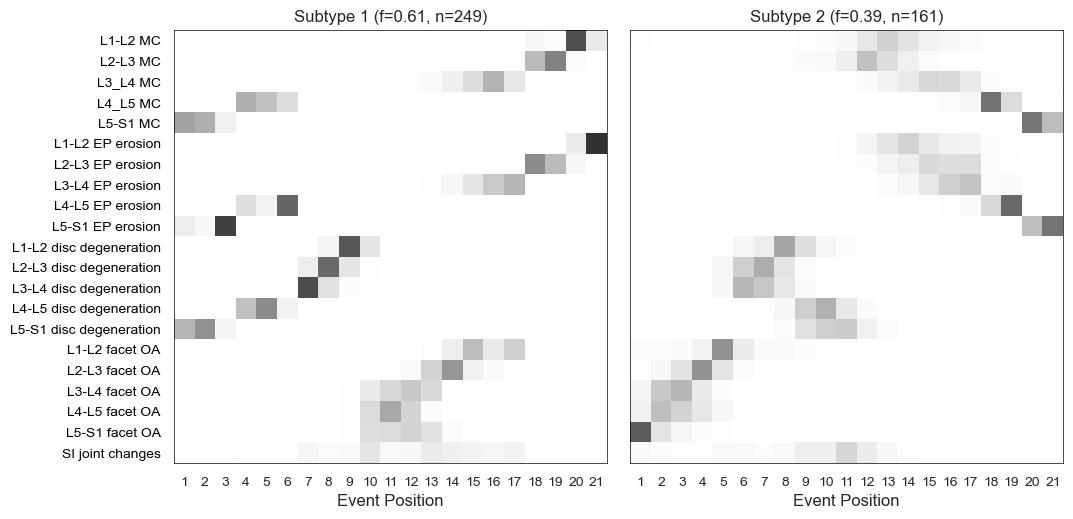

In [ ]:
s = 1
M = df_prob_0.shape[0]
pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pickle_filepath             = Path(pickle_filename_s)
pickle_file                 = open(pickle_filename_s, 'rb')
loaded_variables            = pickle.load(pickle_file)
samples_sequence            = loaded_variables["samples_sequence"]
samples_f                   = loaded_variables["samples_f"]

##### to control ordering of the variables

ml_sequence_EM_full                 = loaded_variables["ml_sequence_EM"]
ml_f_EM_full                        = loaded_variables["ml_f_EM"]
pickle_file.close()

# # order of subtypes displayed in positional variance diagrams plotted by _plot_sustain_model
# plot_subtype_order                  = np.argsort(ml_f_EM_full)[::-1]
# # order of biomarkers in each subtypes' positional variance diagram
# plot_biomarker_order                = ml_sequence_EM_full[plot_subtype_order[1], :].astype(int)


biomarker_labels = [
    'L1-L2 MC', 'L2-L3 MC', 'L3_L4 MC', 'L4_L5 MC','L5-S1 MC',
       'L1-L2 EP erosion', 'L2-L3 EP erosion','L3-L4 EP erosion', 'L4-L5 EP erosion', 'L5-S1 EP erosion',
       'L1-L2 disc degeneration', 'L2-L3 disc degeneration', 'L3-L4 disc degeneration', 'L4-L5 disc degeneration','L5-S1 disc degeneration',
       'L1-L2 facet OA', 'L2-L3 facet OA', 'L3-L4 facet OA', 'L4-L5 facet OA','L5-S1 facet OA',
       'SI joint changes', 
       ]

# make a custom colormap using blues where 0 is white
cmap = sns.color_palette("Greys", as_cmap=True)

# set the low values to white
cmap.set_under('white')

fig, ax = pySuStaIn.MixtureSustain._plot_sustain_model(sustain_input,
                                             samples_sequence,
                                             samples_f,
                                             M,
                                             biomarker_labels = biomarker_labels, 
                                             figsize = (11,11), 
                                             cmap = cmap,
                                             cval = False,
                                             # biomarker_order=plot_biomarker_order,
                                            #  subtype_titles = ['Disc-first subtype (62%, n=253)', 'Facet-first subtype (38%, n=157)'],
                                             # save_path = f'/Users/tmcsween21/Documents/sdtm/tmcs/outputs/{dataset_name}_ordered_by_event_subtype{s}',
                                             # save_path = f'/Users/tmcsween21/Documents/sdtm/tmcs/outputs/{dataset_name}_ordered_by_event_position_subtype2',
                                             save_kwargs = {'format': "pdf"}
                                             )

plt.grid(False)

In [ ]:
s = 1
pickle_filename_s           = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pickle_filepath             = Path(pickle_filename_s)
pickle_file                 = open(pickle_filename_s, 'rb')
loaded_variables            = pickle.load(pickle_file)
ml_subtype                  = loaded_variables["ml_subtype"]
prob_ml_subtype             = loaded_variables["prob_ml_subtype"]
ml_stage                    = loaded_variables["ml_stage"]
prob_ml_stage               = loaded_variables["prob_ml_stage"]
prob_subtype                = loaded_variables["prob_subtype"]
prob_stage                  = loaded_variables["prob_stage"]
prob_subtype_stage          = loaded_variables["prob_subtype_stage"]
pickle_file.close()  
ml_subtype.shape   

results_bl = df_prob_0[['participant_id', 'group', 'visit']].copy()
results_bl['subtype'] = ml_subtype
results_bl['subtype_probability'] = prob_ml_subtype
results_bl['stage'] = ml_stage
results_bl['stage_probability'] = prob_ml_stage

results_bl.to_csv(f'/tmcs/outputs/{dataset_name}_subtype_stage_results.csv', index=False)

# Cross validation

In [926]:
# index_control is the index of the ivdd_label column where the value is 0
index_control = df_prob_0[df_prob_0['group'] == 0].index

# label cases and controls to perform stratified cross-validation
labels                  = df_prob_0['group'].values

# choose the number of folds - here i've used three for speed but i recommend 10 typically
N_folds                  = 5

# generate stratified cross-validation training and test set splits
cv                       = sklearn.model_selection.StratifiedKFold(n_splits=N_folds, 
                                                                   shuffle=True,
                                                                   random_state=42)
cv_it                    = list(cv.split(df_prob_0, labels))

test_idxs                = []
for train, test in cv_it:
    # print("TRAIN:", train, "TEST:", test)
    test_idxs.append(test)
# print(test_idxs)
test_idxs = [np.array(test_idx) for test_idx in test_idxs]
print(test_idxs[0])

[  1   4   6   8  11  33  38  41  45  46  51  53  60  62  63  65  75  79
  80  81  88 101 102 104 113 119 123 137 141 146 147 154 158 162 173 176
 181 182 183 186 207 208 222 226 240 249 251 255 258 259 260 269 276 281
 286 287 300 301 302 303 306 313 317 318 319 321 341 346 348 349 352 355
 359 369 370 376 377 380 392 399 400 403]


In [927]:
# perform cross-validation and output the cross-validation information criterion and
# log-likelihood on the test set for each subtypes model and fold combination
CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6593.746624807907


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6533.15819178]
Overall ML likelihood is [-6533.15819178]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6577.65471180301


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6507.78702648]
Overall ML likelihood is [-6507.78702648]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6580.508967076956


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6511.39996691]
Overall ML likelihood is [-6511.39996691]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6524.59400666527


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6444.45594187]
Overall ML likelihood is [-6444.45594187]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem
Overall ML likelihood is -6589.087092861146


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-6526.89877154]
Overall ML likelihood is [-6526.89877154]


MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

MCMC Iteration:   0%|          | 0/10000 [00:00<?, ?it/s]

Average test set log-likelihood for each subtype model: [-1646.48195987 -1635.20980996]
CVIC for each subtype model: [16453.77244871 16324.18051136]


../outputs/final_models_mayday/pickle_files/strict_ivd_fjoa_controls_included_trained_model_subtype1.pickle


/Users/tmcsween21/Documents/sdtm/pySuStaIn/MixtureSustain.py:354: UserWarning: Both labels and an order have been given. The labels will be reordered according to the given order!
  warnings.warn(


([<Figure size 1100x1100 with 2 Axes>],
 array([<Axes: title={'center': 'Subtype 1 cross-validated'}, xlabel='Event Position'>,
        <Axes: title={'center': 'Subtype 2 cross-validated'}, xlabel='Event Position'>],
       dtype=object))

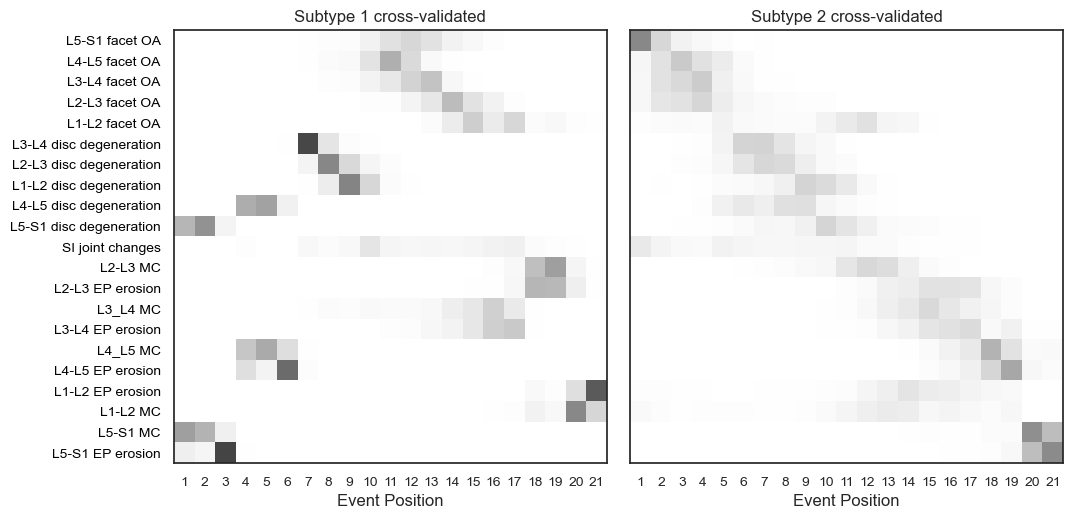

In [ ]:
N_subtypes = 2
dataset_name = 'strict_ivd_fjoa_controls_included_trained_model'
output_folder = '../outputs/final_models_mayday'

pickle_dir                          = os.path.join(output_folder, 'pickle_files')

# load ML sequence for full model for N_subtypes
pickle_filename_s                   = os.path.join(pickle_dir, dataset_name + '_subtype' + str(N_subtypes-1) + '.pickle')        
pickle_filepath                     = Path(pickle_filename_s)

print(pickle_filepath)

pickle_file                         = open(pickle_filename_s, 'rb')


loaded_variables_full               = pickle.load(pickle_file)

ml_sequence_EM_full                 = loaded_variables_full["ml_sequence_EM"]
ml_f_EM_full                        = loaded_variables_full["ml_f_EM"]

for i in range(N_folds):

    #load the MCMC sequences for this fold's model of N_subtypes
    pickle_filename_fold_s          = os.path.join(pickle_dir, dataset_name + '_fold' + str(i) + '_subtype' + str(N_subtypes-1) + '.pickle')        
    pickle_filepath                 = Path(pickle_filename_fold_s)

    assert pickle_filepath.exists(), "Failed to find pickle file for fold " + str(i)

    pickle_file                     = open(pickle_filename_fold_s, 'rb')

    loaded_variables_i              = pickle.load(pickle_file)

    ml_sequence_EM_i                = loaded_variables_i["ml_sequence_EM"]
    ml_f_EM_i                       = loaded_variables_i["ml_f_EM"]

    samples_sequence_i              = loaded_variables_i["samples_sequence"]
    samples_f_i                     = loaded_variables_i["samples_f"]

    # mean_likelihood_subj_test       = loaded_variables_i["mean_likelihood_subj_test"]

    pickle_file.close()

    corr_mat                        = np.zeros((N_subtypes, N_subtypes))
    for j in range(N_subtypes):
        for k in range(N_subtypes):
            corr_mat[j,k]            = stats.kendalltau(ml_sequence_EM_full[j,:], ml_sequence_EM_i[k,:]).correlation
    set_full                        = []
    set_fold_i                      = []
    i_i, i_j                        = np.unravel_index(np.argsort(corr_mat.flatten())[::-1], (N_subtypes, N_subtypes))
    for k in range(len(i_i)):
        if not i_i[k] in set_full and not i_j[k] in set_fold_i:
            set_full.append(i_i[k].astype(int))
            set_fold_i.append(i_j[k].astype(int))
    index_set_full                  = np.argsort(set_full).astype(int) #np.argsort(set_full)[::-1].astype(int)
    iMax_vec                        = [set_fold_i[i] for i in index_set_full]

    assert(np.all(np.sort(iMax_vec)==np.arange(N_subtypes)))

    if i == 0:
        samples_sequence_cval       = samples_sequence_i[iMax_vec,:,:]
        samples_f_cval              = samples_f_i[iMax_vec, :]
    else:
        samples_sequence_cval       = np.concatenate((samples_sequence_cval,    samples_sequence_i[iMax_vec,:,:]),  axis=2)
        samples_f_cval              = np.concatenate((samples_f_cval,           samples_f_i[iMax_vec,:]),           axis=1)

n_samples                           = 1000

plot_subtype_order                  = np.argsort(ml_f_EM_full)[::-1]
# order of biomarkers in each subtypes' positional variance diagram
plot_biomarker_order                = ml_sequence_EM_full[plot_subtype_order[1], :].astype(int)

biomarker_labels = [
       'L1-L2 MC', 'L2-L3 MC', 'L3_L4 MC', 'L4_L5 MC','L5-S1 MC',
       'L1-L2 EP erosion', 'L2-L3 EP erosion','L3-L4 EP erosion', 'L4-L5 EP erosion', 'L5-S1 EP erosion',
       'L1-L2 disc degeneration', 'L2-L3 disc degeneration', 'L3-L4 disc degeneration', 'L4-L5 disc degeneration','L5-S1 disc degeneration',
       'L1-L2 facet OA', 'L2-L3 facet OA', 'L3-L4 facet OA', 'L4-L5 facet OA','L5-S1 facet OA',
       'SI joint changes'
       ]

# make a custom colormap using blues where 0 is white
cmap = sns.color_palette("Greys", as_cmap=True)

# set the low values to white
cmap.set_under('white')

sustain_input._plot_sustain_model(
    samples_sequence=samples_sequence_cval,
    samples_f=samples_f_cval,
    n_samples=n_samples,
    figsize = (11,11), 
    cmap=cmap,
    cval=True,
    biomarker_labels=biomarker_labels,
    subtype_order=plot_subtype_order,
    biomarker_order=plot_biomarker_order,
    save_path = f'{output_folder}/{dataset_name}_ordered_by_event_subtype2',
    save_kwargs = {'format': "pdf"}
)

# Follow-up inferences

In [265]:
df_prob_0 = group_0_prob.copy()
df_prob_1 = group_1_prob.copy()

df_prob_0 = df_prob_0[df_prob_0['group'] == 1]
df_prob_1 = df_prob_1[df_prob_1['group'] == 1]

df_prob_0_fu = df_prob_0[df_prob_0['visit'] == 'follow-up']
df_prob_1_fu = df_prob_1[df_prob_1['visit'] == 'follow-up']

print(df_prob_0_fu.shape)

(61, 206)


In [266]:
df_prob_0_fu_selection = df_prob_0_fu[variable_selection]
df_prob_1_fu_selection = df_prob_1_fu[variable_selection]

N_samples                   = 1000
ml_subtype,                  \
prob_ml_subtype,             \
ml_stage,                    \
prob_ml_stage,               \
prob_subtype,                \
prob_stage,                  \
prob_subtype_stage          = sustain_input.subtype_and_stage_individuals_newData(df_prob_1_fu_selection,
                                                                                df_prob_0_fu_selection, 
                                                                                samples_sequence,
                                                                                samples_f,
                                                                                N_samples)

results_fu = df_prob_0_fu[['participant_id', 'group', 'visit']].copy()
results_fu['subtype'] = ml_subtype
results_fu['subtype_probability'] = prob_ml_subtype
results_fu['stage'] = ml_stage
results_fu['stage_probability'] = prob_ml_stage

results = pd.concat([results_bl, results_fu], axis=0)
results = results.reset_index(drop=True)
results = results_bl.merge(results_fu[['participant_id', 'subtype', 'stage', 'visit']], on='participant_id', how='left')
results = results.dropna(subset=['subtype_y'])
results['subtype_change'] = abs(results['subtype_x'] - results['subtype_y'])


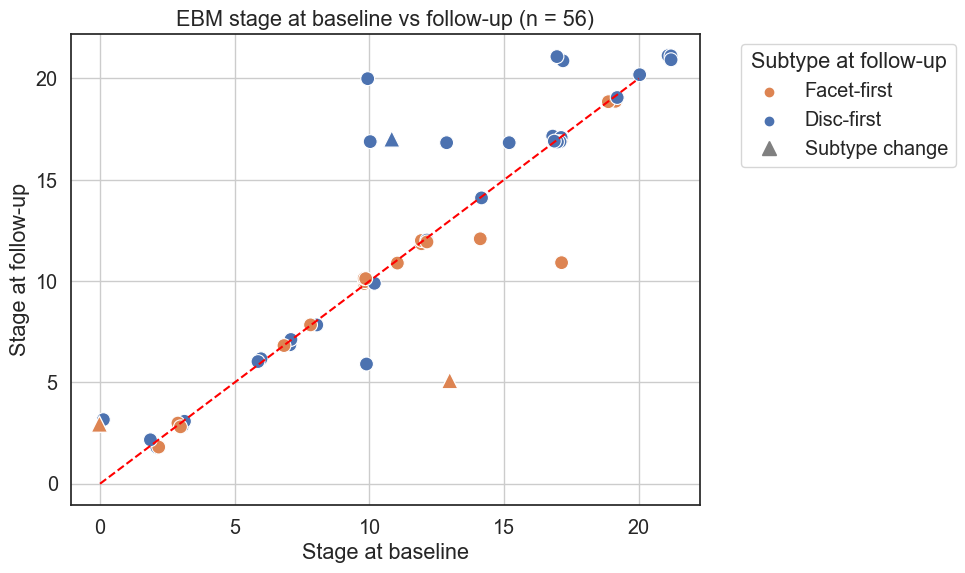

In [ ]:

# Map subtype labels
results['subtype_y'] = results['subtype_y'].map({0: 'Disc-first', 1: 'Facet-first'})

# Split data
results_changed = results[results['subtype_change'] > 0].copy()
results_static = results[results['subtype_change'] == 0].copy()

# Apply jitter
def add_jitter(values, jitter_amount=0.2):
    return values + np.random.uniform(-jitter_amount, jitter_amount, size=values.shape)

results_static['x_jittered'] = add_jitter(results_static['stage_x'])
results_static['y_jittered'] = add_jitter(results_static['stage_y'])
results_changed['x_jittered'] = add_jitter(results_changed['stage_x'])
results_changed['y_jittered'] = add_jitter(results_changed['stage_y'])

# Start plotting
plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette('deep')[:2]
# reversed_palette = custom_palette[::-1]
# Plot static points with circles
sns.scatterplot(data=results_static, x='x_jittered', y='y_jittered',
                hue='subtype_y', s=100, marker='o', 
                palette={'Disc-first': custom_palette[0], 'Facet-first': custom_palette[1]}
                )

# Plot changed points with triangles (no hue used here, but you could add it)
sns.scatterplot(data=results_changed, x='x_jittered', y='y_jittered',
                hue='subtype_y', marker='^', s=140, legend=False)

# Create custom triangle legend handle (black triangle)
triangle_handle = mlines.Line2D([], [], color='grey', marker='^', linestyle='None',
                                markersize=10, label='Subtype Change')
# Decorations
plt.title('EBM stage at baseline vs follow-up (n = 56)')
plt.xlabel('Stage at baseline')
plt.ylabel('Stage at follow-up')
plt.plot([0, 20], [0, 20], color='red', linestyle='--')
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(triangle_handle)
labels.append('Subtype change')

plt.legend(handles=handles, labels=labels, title='Subtype at follow-up',
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(f'/tmcs/outputs/{dataset_name}_subtype_change_plot.pdf', bbox_inches='tight')
plt.show()